<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Tipología y Ciclo de Vida de los Datos - PR2</p>
<p style="margin: 0; text-align:right;">2018-19 · Máster en Ciencia de datos</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Pablo Lombao Vázquez</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Práctica 2 - Data Cleaning: Precios de la energía en el Mercado Ibérico

## 1. Introducción

### 1.1. Descripción del dataset

El conjunto de datos está compuesto por los datos oficiales de la OMIE del precio horario de la energía en EUR/MWh para el mercado ibérico de energía (España y Portugal), a parte del total de Compras y Ventas de energía para los mercados ES y PT, extraidos de la página de la OMIE.es mediante web scraping para las fechas que abarcan desde el 2 de Junio hasta el 20 de Octubre de 2018.

Para cada hora se registra el momento y 10 variables numéricas de mercado siendo por tanto de 11 atributos totales. La mayoría de los atributos numéricos están altamente relacionados mientras que el atributo Fecha esconde en sí mismo varios atributos interesantes: fecha, hora, día de la semana o estación. Queremos estudiar concretamente el **precio de la energía y su comportamiento en el tiempo** por lo que los datos se transformarán para obtener un conjunto con **3407 registros y 8 atributos**, los cuales serán:

* **Fecha**: fecha y hora de la medida (un registro por cada hora)

* **Precio**: precio de la energía en euros por MWh

* **hour**: hora del día

* **dayofweek**: día de la semana

* **quarter**: cuatrimestre del año

* **month**: mes del año 

* **night**: variable dummie que determina si la medida ocurre de noche (23 a 07)

* **weekend**: variable dummie que determina si es fin de semana (sabado y domingo)

### 1.2. Objetivos

El presente documento tiene como objetivo el estudio analítico del precio de la energía en el mercado ibérico y su comportamiento en relación a la estacionalidad, en concreto queremos saber:

- Missings y outliers que contiene el conjunto de datos y como tratarlos.
- Diferencia en el comportamiento del precio de la energía entre un día entre semana y un día de finde.
- Modelización del comportamiento del precio de la energía respecto a las variables de seasonability (hora, día de la semana, mes...).

## 2. Integración y selección de datos

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Importamos los datos
df = pd.read_csv('OMIE_20180601_20181020.csv', parse_dates=True)

# Cambiamos el formato de la columna Fecha a datetime
df['Fecha'] = df['Fecha'].apply(pd.to_datetime, format = '%d/%m/%Y %H:%M', errors='coerce')

# Ponemos la fecha como indice
df = df.set_index('Fecha')

De un primer vistazo al dataset ya nos damos cuenta e que hay variables que son en realidad la misma, vamos a realizar unas pequeñas representaciones gráficas para poder descartar datos que no son de interés.

In [4]:
# Comprobamos que la columna 0 y 2 son iguales
((df.iloc[:,0] - df.iloc[:,2])>0).sum()

0

In [5]:
# Comprobamos que la columna 1 y 3 son iguales
((df.iloc[:,1] - df.iloc[:,3])>0).sum()

0

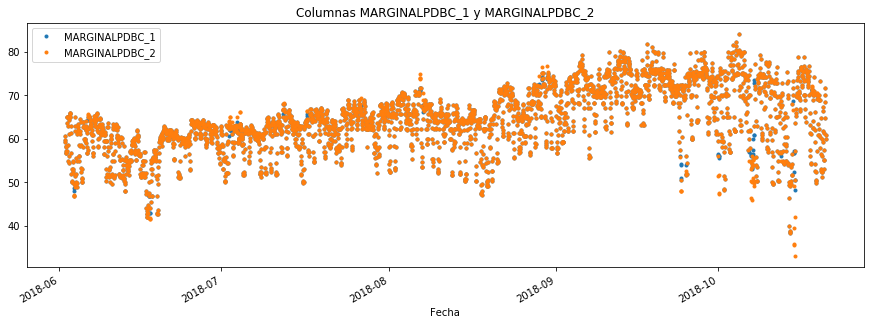

In [6]:
df.iloc[:,[0,1]].plot(style='.', figsize=(15,5), title='Columnas MARGINALPDBC_1 y MARGINALPDBC_2')

- Eliminamos las columnas 2 y 3 (MARGINALPDBCPT_1 y MARGINALPDBCPT_2) porque son exactamente las mismas a 0 y 2.
- Eliminamos la columna 1 porque es el mismo concepto que la columna 0 y como vemos en la gráfica arriba, apenas difiere de la misma.
- Eliminamos las columnas 8 y 9 por ser una combinación de otras columnas

Por otra parte, vamos a crear unos indicativos de temporalidad a partir del campo fecha: hora, día de la semana, mes y cuatrimestre del año.

In [7]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['weekday'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['night'] = np.logical_or(df['hour']<8,df['hour']>22)
    df['weekend'] = df['weekday']>4

    return df

df = create_features(df)
df = df.iloc[:,[0,8,9,11,12,13,14,15,16]]
df.columns = ['Precio','Compras','Ventas'] + list(df.columns[-6:])
df.head()

,Precio,Compras,Ventas,hour,weekday,quarter,month,night,weekend
Fecha,,,,,,,,,
2018-06-02 00:00:00,60.69,23658.9,21458.9,0,5,2,6,True,True
2018-06-02 01:00:00,59.74,22318.6,20118.6,1,5,2,6,True,True
2018-06-02 02:00:00,59.30,20840.6,19340.6,2,5,2,6,True,True
2018-06-02 03:00:00,58.33,19945.6,18445.6,3,5,2,6,True,True
2018-06-02 04:00:00,58.00,19345.1,17845.1,4,5,2,6,True,True


Este es el aspecto que tendrá el conjunto de datos de trabajo desde aquí en adelante, tal y como lo habíamos definido en la primera sección.

## 3. Data cleaning

Vamos a proceder a limpiar los datos y particularmente, a estudiar y corregir los outliers y missings.

### 3.1. Missings

Los missings o valores perdidos se tratan de valores nulos o vacíos que corresponden a valores no válidos de nuestro conjunto de datos, ya sea por que se han perdido, porque están corruptos, porque no existe la información o porque no se tomó adecuadamente.

In [17]:
def report_missings(data, return_missings=False):
    """
    Coge un dataframe, informa de sus missings
    y si lo indicamos, devuelve una tabla con las
    columnas con missings, el número de missings y
    el porcentaje de missings
    """
    # getting the sum of null values and ordering
    total = data.isnull().sum().sort_values(ascending = False)
    # getting the percent and order of null
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False)
    # Concatenating the total and percent
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    # Returning values of nulls different of 0
    missings = df[~(df['Total'] == 0)]
    print("MISSINGS VALUES REPORT:")
    print(missings)
    print("==============================================================")
    total = missings.sum(axis=0)
    print("Total Missings in the df: {} value/s".format(str(int(total[0]))))
    print("Total % of Missings in the df: {} %".format(str(round(total[1],2))))
    print("==============================================================")
    print("Total rows: {}".format(str(data.shape)))
    print("Total rows with NO missings in df: {} rows".format(str(data.dropna().shape[0])))

    if return_missings: return missings
    
report_missings(df)

MISSINGS VALUES REPORT:
Empty DataFrame
Columns: [Total, Percent]
Index: []
Total Missings in the df: 0 value/s
Total % of Missings in the df: 0.0 %
Total rows: (3408, 9)
Total rows with NO missings in df: 3408 rows


Como vemos **no tenemos missings en nuestro conjunto de datos**. 

Si los tuvieramos, podríamos usar las siguientes thumb rules:

- Eliminar columnas por encima del 60-70% de missings para variables no fundamentales.
- Eliminar filas con más de dos variables missings.
- Asignar el resto de missings.

El método podría ser el de **interpolación lineal con correcciones estacionales** debido a que se trata de un time-series sobre la que podemos asumir que sigue una tendencia y que es estacional (depende de variables temporales como época del año, día...). 

Otros métodos que podríamos usar sobre nuestros datos para imputación de missings:

- Asignación mediante valores de tendencia central: media, media recortada, mediana o media winsorizada
- Asignación mediante ratio imputation
- Modelo de regresión lineal o logística
- Imputación mediante técnicas de Machine Learning como el algoritmo kNN, XGBoost o Random Forest.

### 3.2. Outliers

Los outliers son valores extremos que se desmarcan del rango "esperado" para una determinada distribución univariable. Estos valores afectan en gran medida a los análisis realizados sobre dichos datos, alterando los resultados. No obstante, no todos los outliers son en realidad valores no válidos sino que depende de la naturaleza de la medida y del contexto concreto. Matemáticamente podemos definir a los outliers de dos formas distintas:

+ Método Zscore: Valores que estén a una distancia de la media igual o mayor a 3 veces la desviación estándar, cuya probabilidad de aparición es de 0.26% para distribuciones normales.

+ Método RIC: Valores a más de 1.5 veces el rango intercuartílico de la distribución (distancia entre el perceptil 75 y el 25)

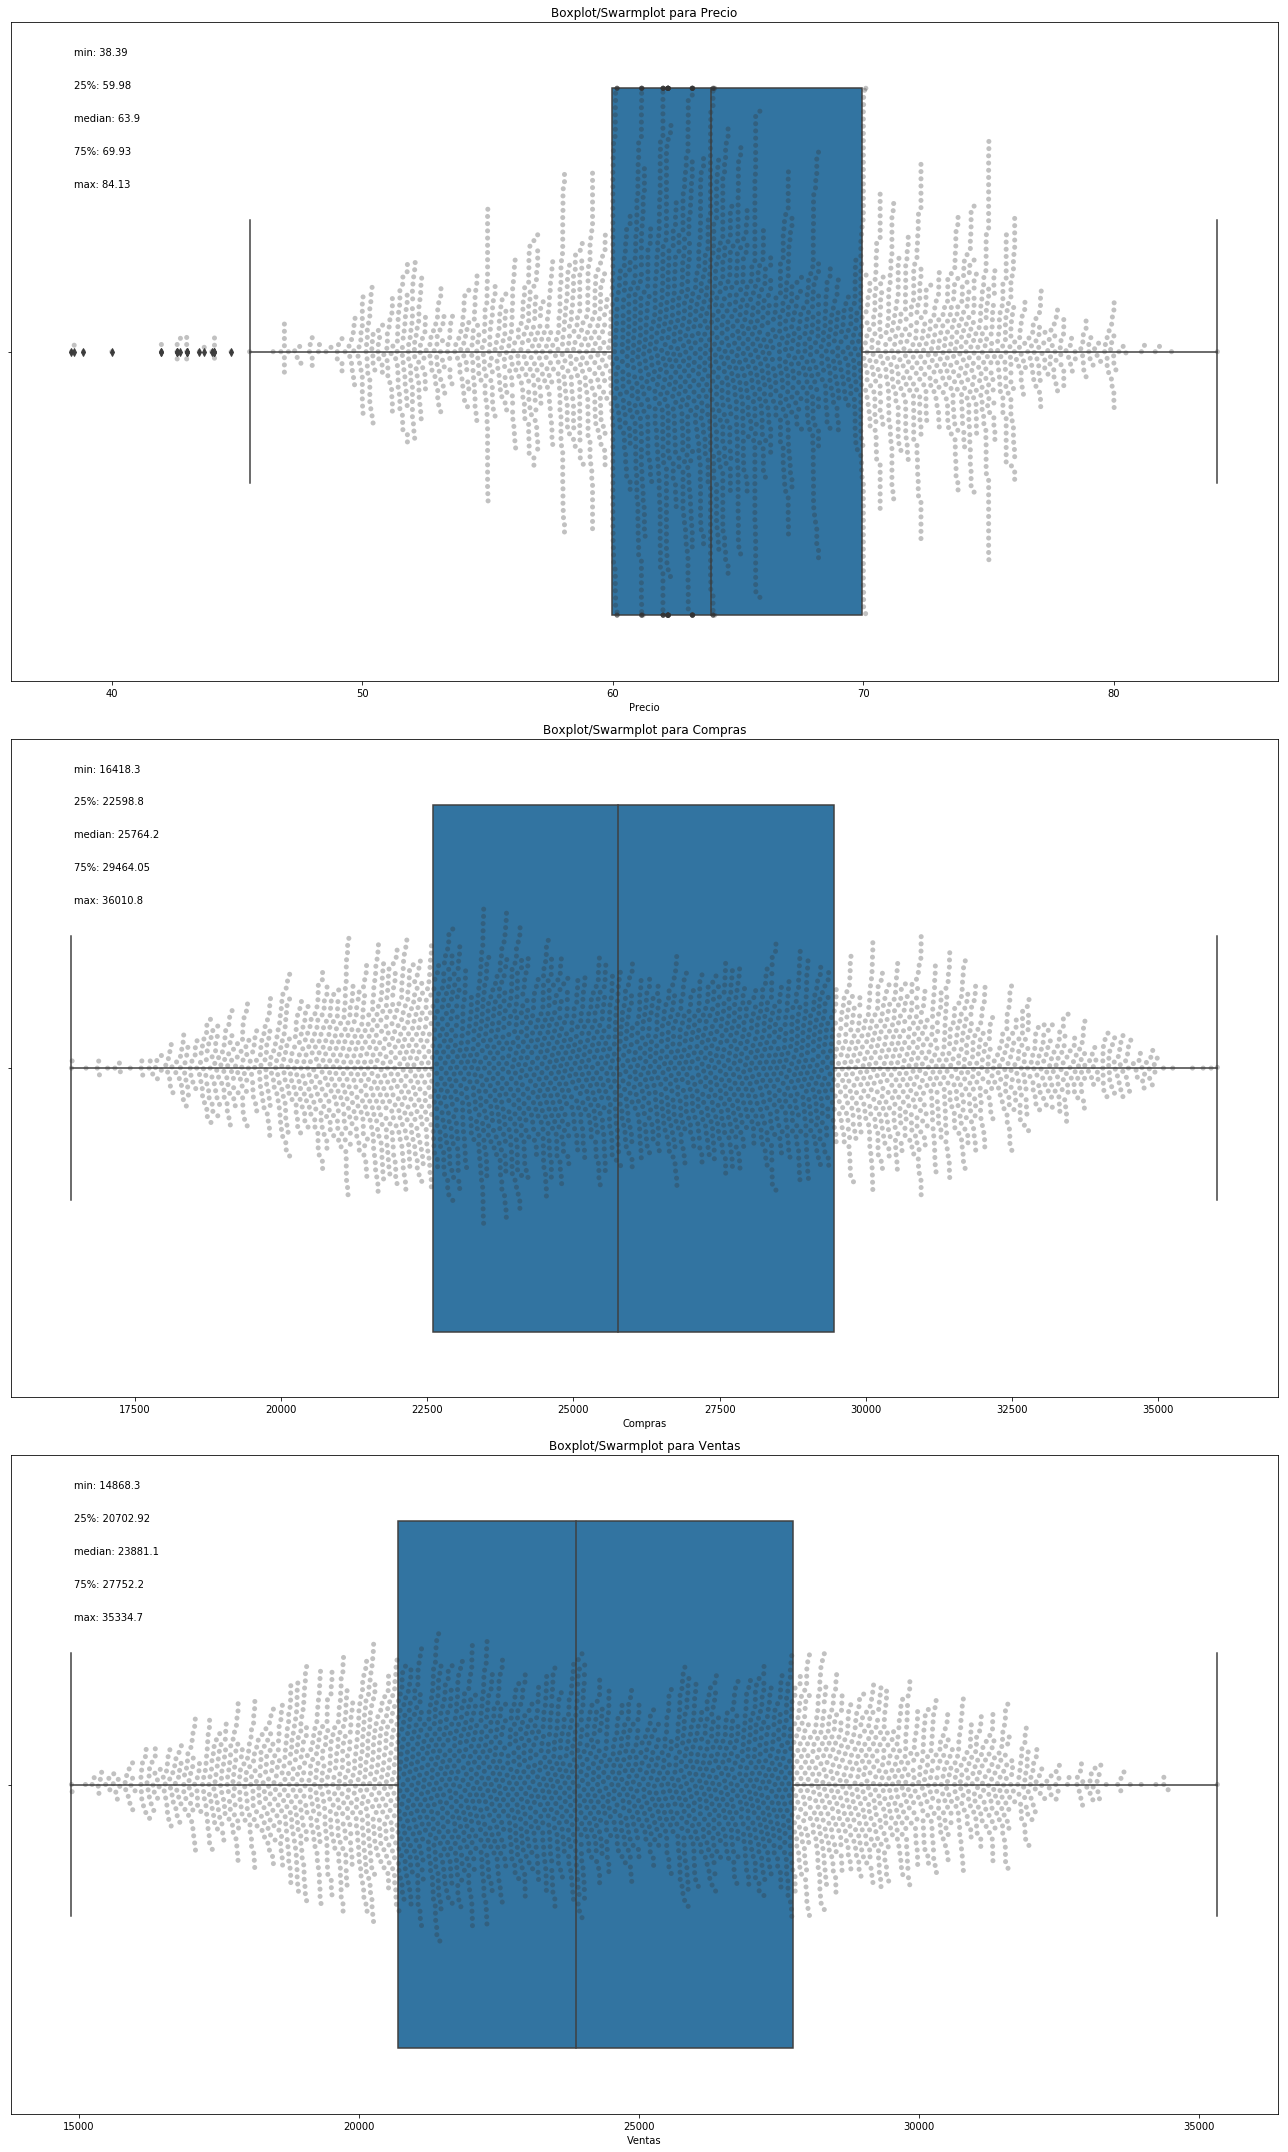

In [94]:
def plotBoxSwarm(data):
    sns.boxplot(data)
    ax = sns.swarmplot(data, color=".2", alpha=0.3)
    plt.title('Boxplot/Swarmplot para {}'.format(data.name))
    ytext=0.95
    for quan, name in zip([0, 0.25, 0.5, 0.75, 1],['min','25%','median','75%','max']):
        ax.text(0.05, ytext,name +': {}'.format(round(data.quantile(quan),2)),
            transform=ax.transAxes)
        ytext -= 0.05
        
plt.figure(figsize=(18, 30))
i=1
for column in df.columns[0:3]:
    plt.subplot(3,1,i)
    plotBoxSwarm(df[column])
    i+=1
plt.tight_layout()
plt.show()

In [8]:
data = df['Precio']
# Calculamos los quartiles q1, q3
q1, q3 = data.quantile(0.25), data.quantile(0.75)
# Calculamos el RIC
ric = q3 - q1
# Calculamos la matriz mask de outliers
mask = (data < (q1 - 1.5*ric)) | (data > (q3 + 1.5*ric))
outliers = df[mask]
# Calculamos el numero de outliers por columna
print("OUTLIERS VALUES REPORT - RIC method:")
print("Total outliers: {}".format(len(outliers)))
print("==============================================================")
outliers

OUTLIERS VALUES REPORT - RIC method:
Total outliers: 21


,Precio,Compras,Ventas,hour,weekday,quarter,month,night,weekend
Fecha,,,,,,,,,
2018-06-17 02:00:00,44.10,19423.2,17623.2,2,6,2,6,True,True
2018-06-17 03:00:00,43.49,19029.2,17229.2,3,6,2,6,True,True
2018-06-17 04:00:00,42.74,18836.3,17036.3,4,6,2,6,True,True
2018-06-17 05:00:00,42.61,18674.8,16874.8,5,6,2,6,True,True
2018-06-17 06:00:00,41.98,18478.7,16678.7,6,6,2,6,True,True
2018-06-17 07:00:00,41.98,18449.4,16649.4,7,6,2,6,True,True
2018-06-17 08:00:00,42.99,18740.1,16940.1,8,6,2,6,False,True
2018-06-17 09:00:00,44.10,20190.2,18390.2,9,6,2,6,False,True
2018-06-17 10:00:00,44.10,21294.7,19494.7,10,6,2,6,False,True


In [10]:
from scipy import stats 

mask = np.abs(stats.zscore(data)) > 3
outliers = df[mask]
# Calculamos el numero de outliers por columna
print("OUTLIERS VALUES REPORT - Zscore method:")
print("Total outliers: {}".format(len(outliers)))
print("==============================================================")
outliers

OUTLIERS VALUES REPORT - Zscore method:
Total outliers: 6


,Precio,Compras,Ventas,hour,weekday,quarter,month,night,weekend
Fecha,,,,,,,,,
2018-06-17 06:00:00,41.98,18478.7,16678.7,6,6,2,6,True,True
2018-06-17 07:00:00,41.98,18449.4,16649.4,7,6,2,6,True,True
2018-10-14 05:00:00,40.00,22429.4,20229.4,5,6,4,10,True,True
2018-10-14 06:00:00,38.39,22846.1,20646.1,6,6,4,10,True,True
2018-10-14 07:00:00,38.50,23413.9,21213.9,7,6,4,10,True,True
2018-10-14 08:00:00,38.87,23420.2,21426.2,8,6,4,10,False,True


Vemos que el resultado se resume en que obtenemos valores extremos para la variable precio en 21 registros mediante el método del rango intercuartílico mientras que la cifra baja a 6 usando el zscore y un threshold de 3 veces la desviación típica de la distribución. **Importante recalcar que los 6 valores obtenidos bajo el método de zscore están incluidos en los 21 del método RIC**.

En general los datos extremos obtenidos se trata en realidad de **cuatro periodos en los que el precio de la energía es inusualmente bajo**:

* El día 17 de junio entre las 2 y las 11 de la mañana.
* El mismo día 17 de junio entre las 18 y las 20 de la tarde.
* El día 18 de junio entre las 2 y las 5 de la mañana.
* El día 14 de octubre entre las 5 y las 8 de la mañana.

Los datos corresponden en su mayoría **a periodos valle**, donde es esperable valores bajos del precio de la energía y donde por razones diferentes pueden caer a valores extremos. Estos son, por ejemplo, una producción eólica o solar especialmente alta o una demanda esperada baja. **El 17/06 y el 14/10 fueron domingo**, donde también se esperan precios bajos. Caso disinto es el de los registros para el 17/06 a las 18, 19 y 20 de la mañana, donde los resultados pueden rechinar algo más.

De todas formas, **hay que entender estos datos en su contexto**, es decir, con datos de energía entre junio y octubre estos datos resultan extraños, quizás, en un conjunto más grande (con años de datos), la distribución sería distinta y el "límite" que demarca los outliers probablemente más ancho. **En general, ños valores son coherentes y no nos hacen pensar que sean incorrectos, solo "extremos", por lo que los damos como valores válidos**.

In [13]:
# Guardamos los datos clean en un fichero csv
df = df.reset_index()
df.to_csv("OMIEdata_clean.csv", index=False)

### 3.3. Exploratory Data Analysis.

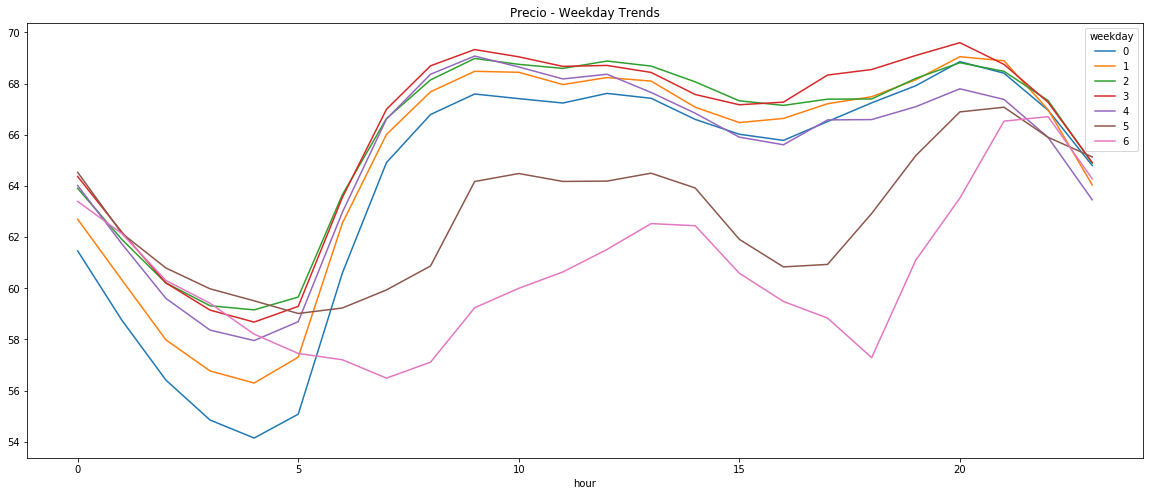

In [63]:
_ = df.pivot_table(index=df['hour'], 
                     columns='weekday', 
                     values='Precio',
                     aggfunc='mean').plot(figsize=(20,8),
                     title='Precio - Weekday Trends')

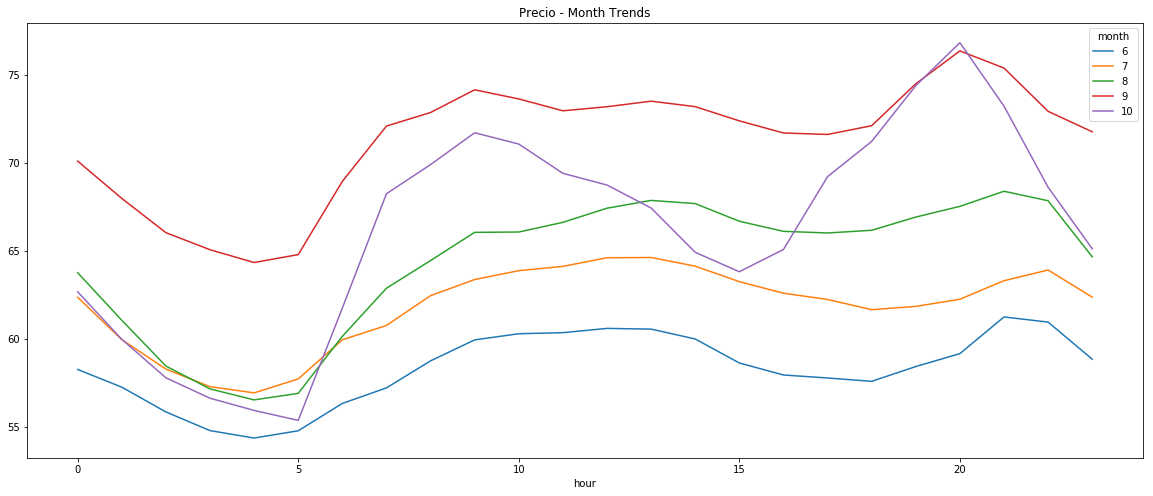

In [52]:
_ = df2.pivot_table(index=df['hour'], 
                     columns='month', 
                     values='Precio',
                     aggfunc='mean').plot(figsize=(20,8),
                     title='Precio - Month Trends')

In [2]:
from plotly.offline import init_notebook_mode, iplot, plot 
init_notebook_mode(connected=True)
import plotly.graph_objs as go 

def timePlot(data1, **kwargs):
    data2 = kwargs.get('data2', None)
    data3 = kwargs.get('data3', None)
    
    #seting some static color options
    color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
                '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
                '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']


    # creating the first trace with the necessary parameters
    trace1 = go.Scatter(x=data1.index, y=data1,
                        opacity = 0.8, line = dict(color = color_op[3]), name= data1.name+ ' by day')
    traces = [trace1]
    try:
        trace2 = go.Scatter(x=data2.index, y=data2,
                        opacity = 0.8, line = dict(color = color_op[5]), name= data2.name+ ' by day', yaxis='y2')
        traces.append(trace2)
    except:
        pass
    try:
        trace3 = go.Scatter(x=data3.index, y=data3,
                        opacity = 0.8, line = dict(color = color_op[7]), name= data3.name+ ' by day')
        traces.append(trace3)
    except:
        pass
    

    #creating the layout the will allow us to give an title and 
    # give us some interesting options to handle with the outputs of graphs
    layout = dict(
        title= "Information by Date",
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label='1m', step='month', stepmode='backward'),
                    dict(count=3, label='3m', step='month', stepmode='backward'),
                    dict(count=6, label='6m', step='month', stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(visible = True),
            type='date'
        ),
        yaxis=dict(
        title=''
        ),
        yaxis2=dict(
            title='',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        )
    )
    
    
    # creating figure with the both traces and layout
    fig = dict(data= traces, layout=layout)

    #rendering the graphs
    iplot(fig) #it's an equivalent to plt.show()

ModuleNotFoundError: No module named 'plotly'

## 4. Análisis de los datos.

### 4.2. Test de normalidad

En primer lugar vamos a comprobar que la **variable precio de la energía se comporte de manera gaussiana o normal**, para ello vamos a llevar a cabo una serie de tests de normalidad, que se basan generalmente en los mismos principios:

* Se realizan bajo la suposición de que las muestras son independientes e igualmente distribuidas.
* Las hipótesis son las siguientes:

\begin{align}
\ H_0: distribucion \; normal\\
\ H_1: distribución \; no \; normal
\end{align}

Las particularidades de cada test quedan fueran del alcance de este documento, en general cada uno comprueba aspectos de una población normal. Nos basta con saber que un buen criterio es rechazar la hipótesis de normalidad si alguno de los test rechaza la hipótesis nula.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


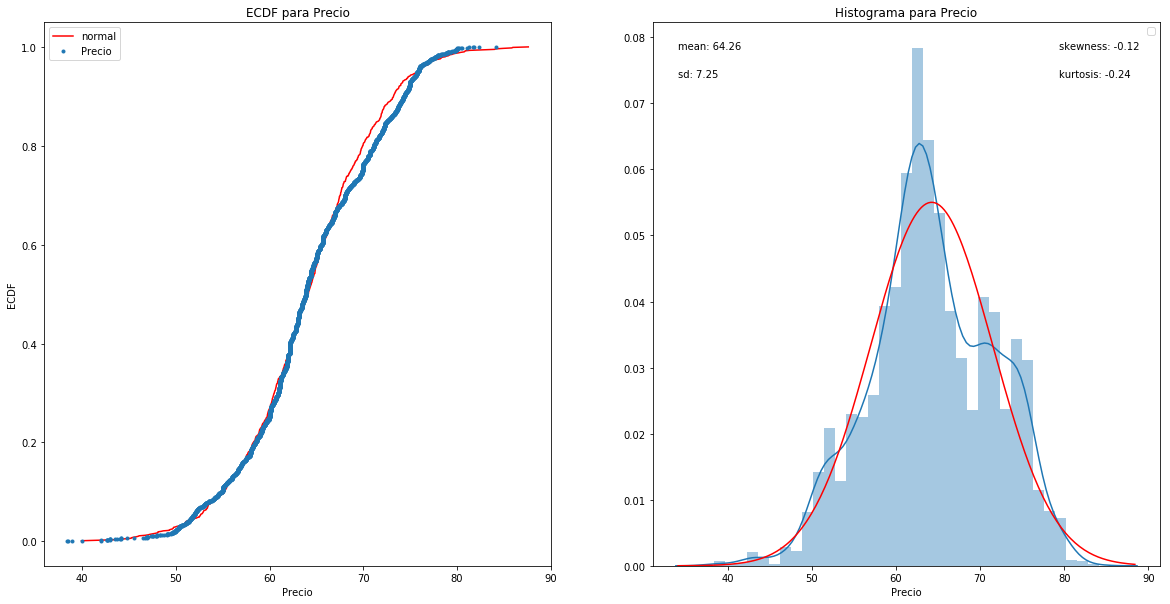

In [47]:
from scipy.stats import kurtosis, skew
from scipy.stats import norm
def plotHist(data,n_bins=None):
    """
    if n_bins = None : Freedman-Diaconis rule
    """
    ax = sns.distplot(data, bins = n_bins, fit=norm, fit_kws={"color":"red"})
    plt.title('Histograma para {}'.format(data.name))
    ax.text(0.8, 0.9,'kurtosis: {}'.format(round(kurtosis(data),2)),
            transform=ax.transAxes)
    ax.text(0.8, 0.95, 'skewness: {}'.format(round(skew(data),2)),
           transform=ax.transAxes)
    ax.text(0.05, 0.95,'mean: {}'.format(round(data.mean(),2)),
            transform=ax.transAxes)
    ax.text(0.05, 0.9, 'sd: {}'.format(round(data.std(),2)),
            transform=ax.transAxes)
    ax.legend()

def plotECDF(data):
    """
    Plot ECDF for a variable and the
    ECDF for a normal distribution with same mean and std
    """
    # create normal distribution with same mean and std as data
    normal = np.random.normal(np.mean(data), np.std(data), 1000)
    # Compute ecdf and plot it in red line
    xvers, yvers = np.sort(normal), np.arange(1, len(normal)+1) / len(normal)
    plt.plot(xvers, yvers, color='red', label='normal')
    xvers, yvers = np.sort(data), np.arange(1, len(data)+1) / len(data)
    plt.plot(xvers, yvers, marker = '.', linestyle = 'none', label=data.name)
    plt.xlabel(data.name)
    plt.ylabel('ECDF')
    plt.title('ECDF para {}'.format(data.name))
    plt.legend()
    
data = df['Precio']
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plotECDF(data)
plt.subplot(1,2,2)
plotHist(data)

In [48]:
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
def normality_test(data, alpha=0.05):
    """
    Funcion que nos devuelve los resultados
    de 3 tests distintos de normalidad
    """
    print("Normality Test:")
    print("====================================================")
    print("Shapiro-Wilk test:")
    print("")
    # normality test
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    
    print("====================================================")
    print("D'Agostino and Pearson's Test:")
    print("")
    # normality test
    stat, p = normaltest(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
        
    print("====================================================")
    print("Anderson-Darling Test:")
    print("")
    # normality test
    result = anderson(data)
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
    
normality_test(df['Precio'])

Normality Test:
Shapiro-Wilk test:

Statistics=0.992, p=0.000
Sample does not look Gaussian (reject H0)
D'Agostino and Pearson's Test:

Statistics=18.194, p=0.000
Sample does not look Gaussian (reject H0)
Anderson-Darling Test:

Statistic: 8.413
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


Hemos llevado a cabo 3 tipos de tests de normalidad distintos sobre nuestras variables numéricas, obteniendo un **rechazo de la hipótesis nula** en todos los casos **con mucha confianza**. En general, un solo rechazo de cualquiera de las hipótesis nula presentadas en estos tests sería suficiente para decir que los datos no son normales. EN este caso, estamos rotundamente seguros de que **ninguna de las 3 variables numéricas se comporta de forma normal**.

### 4.3. Test de homegeneidad de la varianza

Vamos a realizar un test de homogeneidad de la varianza para comprobar que la varianza de las poblaciones correspondientes a los precios de la energía en fin de semana es igual que la varianza de las medidas durante la semana. Para ello realizaremos hasta tres tipos de tests: **Levene, Bartlett y Fligner-Killeen**.

Los tests se basan en las siguientes hipótesis:

\begin{align}
\ H_0: \sigma_1 = \sigma_2 \\
\ H_1: \sigma_1 \neq \sigma_2
\end{align}

Realizamos el test de Bartlett también, aunque al ser muestras no normales, el test de Barlett no nos dirá nada al ser poco robusto ante estas poblaciones.

In [82]:
from scipy.stats import levene, bartlett, fligner

# Poblaciones (findes vs dias de semana)
weekend = df[df.weekend==True]['Precio']
workday = df[df.weekend==False]['Precio']

stat, p = levene(weekend, workday)
print('Levene Test')
print('Statistics=%.3f, p=%.3f' % (stat, p))
print('===================================================')
print('Bartlett Test')
stat, p = bartlett(weekend, workday)
print('Statistics=%.3f, p=%.3f' % (stat, p))
print('===================================================')
print('Fligner Test')
stat, p = fligner(weekend, workday)
print('Statistics=%.3f, p=%.3f' % (stat, p))
print('===================================================')

Levene Test
Statistics=0.462, p=0.497
Bartlett Test
Statistics=0.063, p=0.803
Fligner Test
Statistics=0.515, p=0.473


Todos los tests realizados **fallan al rechazar la hipótesis nula**, por lo que podemos concluir que **las varianzas de nuestras poblaciones son iguales**.

### 4.4. ¿Es el precio de la energía superior en días de semana que en fin de semanas?

Durante los fin de semanas, la mayoría de las industrias y actividades comerciales cesan con lo que el consumo energético cae y los precios bajan. Esto es algo bastante básico y que se confirma al observar la siguiente gráfica donde vemos que durante el día la media de precio por MWh es mucho más baja para el sábado y especialmente el domingo. Algo también lógico es que durante la noche, el precio es más barato, y mucho más durante las noches del domingo al lunes y del lunes al martes, donde se espera una menor actividad lúdica.

El objetivo de esta sección sera comprobar si esta diferencia en el precio entre un día de semana y un día de fin de semana es estadísticamente significativa. Suponemos los datos no apareados por que estrictamente no se trata de la misma población medida en dos momentos distintos en el tiempo, sino es una población que evoluciona. Además, aunque los resultados demostraban **no normalidad** podemos asumir **distribución normal si el número de muestras es mayor a 30 por el Teorema del Límite Central**, el cual es nuestro caso.

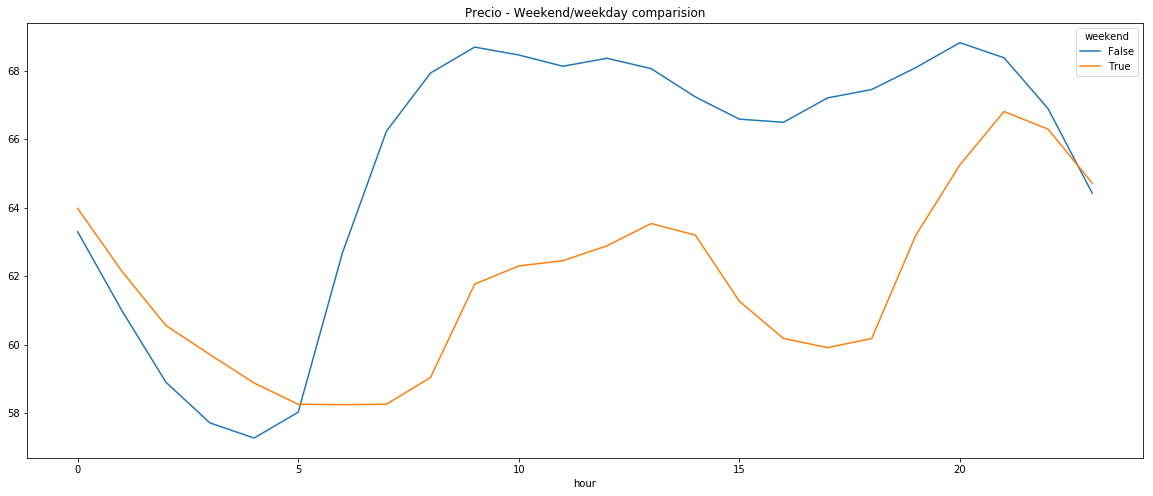

In [58]:
_ = df.pivot_table(index=df['hour'], 
                     columns='weekend', 
                     values='Precio',
                     aggfunc='mean').plot(figsize=(20,8),
                     title='Precio - Weekend/weekday comparision')

In [74]:
# Medias y cuentas de los dos conjuntos
df.groupby('weekend').agg(['count','mean'])['Precio']

,count,mean
weekend,,
False,2424,65.263127
True,984,61.790325


In [72]:
from scipy.stats import ttest_ind
stat, p = ttest_ind(weekend, workday)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-12.976, p=0.000


In [75]:
# Test de Mann-Whitney U para distribuciones no normales/varianzas distintas
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(weekend, workday)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=876101.000, p=0.000


El resultado de nuestro test es bastante contudente, **se rechaza la hipótesis nula** con amplia confianza, con lo cual **la diferencia entre las medias es estadísticamente significativa**.

Este resultado se repite tanto para nuestro test parámetrico (student t-test) como para nuestro test no parámetrico Mann-Whitney U.

### 4.4. Estudio de correlación

Vamos a estudiar la correlación existente entre la variable Precio y las variables Ventas y Compras para demostrar que están altamente relacionadas. Como se trata de poblaciones demostradamente no normales, usamos el **test de Spearman's Rank Correlation**. Como podemos ver en el heatmap siguiente, la correlación parece existir entre las variables, con coeficiente de Pearson en valor absoluto cercanos al 0.5.

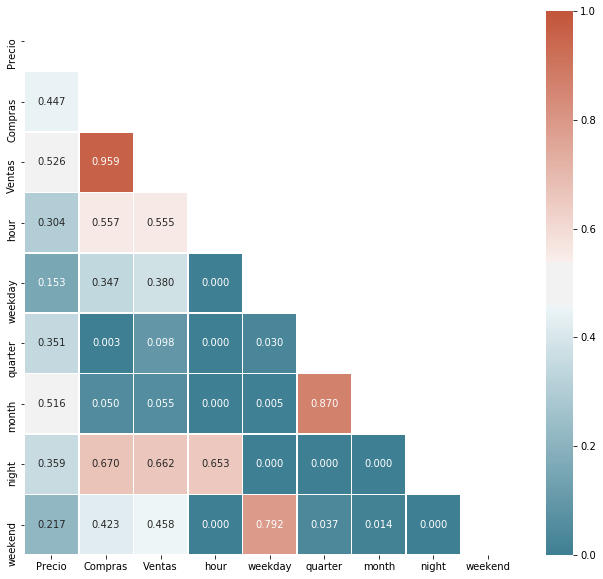

In [56]:
def plotHeatMap(df):
    df = df.dropna()
    # Calculamos la correlacion entre atributos
    corr = df.corr().abs()
    
    # Generamos una máscara triangular (una matriz del mismo tamaño que la matriz
    # de correlaciones, con valores False en el triángulo inferior y True en el resto).
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Generamos la figura matplotlib.
    f, ax = plt.subplots(figsize=(11, 10))
    
    # Creamos un mapa de colores.
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    
    # Dibujamos el mapa de calor, utilizando como máscara la matriz mask y
    # los colores especificados.
    sns.heatmap(corr, mask=mask, cmap=cmap, 
                xticklabels=list(df), yticklabels=(list(df)),
                annot=True, fmt=".3f",
                linewidths=.5, ax=ax)
    
#plotHeatMap(df.iloc[:,:3])
plotHeatMap(df)

In [93]:
from scipy.stats import spearmanr

df = df
var = 'Precio'
def correlation_test(df, var, typ='spearman'):
    corr_dict = {}
    for col in df.columns:
        if col != var:
            if typ == 'spearman':
                corr_dict[col] = spearmanr(df[var], df[col])
    return pd.DataFrame(corr_dict, index=[typ + ' coef.', 'p-value'])

correlation_test(df, 'Precio')

,Compras,Ventas,hour,weekday,quarter,month,night,weekend
spearman coef.,4.672237e-01,5.443645e-01,3.103599e-01,-1.517167e-01,3.695640e-01,5.417399e-01,-3.697039e-01,-2.083111e-01
p-value,2.065339e-184,2.925416e-262,5.408121e-77,5.325479e-19,9.029497e-111,2.873291e-259,7.359477e-111,1.007298e-34
